# Module Import Cell

In [1]:
%matplotlib inline
import matplotlib
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
plt.style.use('ggplot') 

## Data Import Cell

In [2]:
#Available population density by state and year meassured in persons per square mile
pop_df = pd.read_csv('data/Historical_Population_Density_States_only_RAND_US_1.csv')
#---------------------------------------------------------------------------------------
#Available firearm background check data
nics_df = pd.read_csv('data/nics-firearm-background-checks.csv')

### Cleaning population data

In [3]:
#Droping NA Values
cleaner_pop_df = pop_df.dropna(axis=1)
#Keeping area and years from 1999 - 2018
cleaner_pop_df = cleaner_pop_df.loc[:, ['Area'] + list(map(str, range(1999, 2019)))]
#Rename 'Area' column to be more descriptive
my_pop_df = cleaner_pop_df.rename(columns={'Area': 'State'})
#test: expect 52 rows(50 states, DC, and US), 21 columns(State name + data from 1999 - 2018)
#my_pop_df.info()
my_pop_df.shape

(52, 21)

### Cleaning NICS data

In [4]:
#Change month to y-m for year by month
nics_df = nics_df.rename(columns={'month': 'y&m'})
#Add year column to group by
nics_df['year'] = list(map(lambda x: x.split('-')[0], nics_df['y&m']))
#Defining columns to combine
handgun_list = ['handgun', 'prepawn_handgun', 'redemption_handgun', 'returned_handgun', 'rentals_handgun', 'private_sale_handgun', 'return_to_seller_handgun']
long_gun_list = ['long_gun', 'prepawn_long_gun', 'redemption_long_gun', 'returned_long_gun', 'rentals_long_gun', 'private_sale_long_gun', 'return_to_seller_long_gun']
#Create combined columns
nics_df['total_handgun'] = nics_df[handgun_list].sum(axis=1)
nics_df['total_long_gun'] = nics_df[long_gun_list].sum(axis=1)
#Group by year then state
year_state_group = nics_df.groupby(('year', 'state')).sum()
#Collect the columns we want and reset index
clean_nics_df = year_state_group[['total_handgun', 'total_long_gun']]
clean_nics_df = clean_nics_df.reset_index()
#Remove any year not between 1999 and 2018 and assign to my_nics_df
clean_nics_df['year'] = pd.to_numeric(clean_nics_df['year'])
my_nics_df = clean_nics_df.loc[(clean_nics_df['year'] < 2019) & (clean_nics_df['year'] > 1998)] 
#Test: Expect 1100 rows (50 states + DC, Guam, Puerto Rico, Mariana Islands, and Virgin Islands X 20 years) and 4 columns
my_nics_df.shape

(1100, 4)

#### Selecting for 2018

In [5]:
#Select the states and population density for 2018, then remove the united states row
my_2018_pop_df = my_pop_df.loc[:, ['State', '2018']]
my_2018_pop_df = my_2018_pop_df[my_2018_pop_df['State'] != 'United States']
#Selecting for year = 2018 and needed rows from NICS data.
nics_2018_df = my_nics_df[my_nics_df['year'] == 2018]
rows_to_drop = ['Guam', 'Mariana Islands', 'Puerto Rico', 'Virgin Islands']
for row in rows_to_drop:
    nics_2018_df = nics_2018_df[nics_2018_df['state'] != row]
#New Variables
  #my_2018_pop_df
  #nics_2018_df

#### Combining and agregating for graphing

In [6]:
#Add population density to NICS data
temp = np.array(my_2018_pop_df['2018'])
nics_2018_df['pop_density'] = temp
#Add column to show ratio of handgun/ rifle applications
nics_2018_df['handgun/long_gun'] = nics_2018_df['total_handgun'] / nics_2018_df['total_long_gun']
#Sorting DF by population density
pop_sorted_nics_2018_df = nics_2018_df.sort_values('pop_density')

# Graphs

## Graph 1

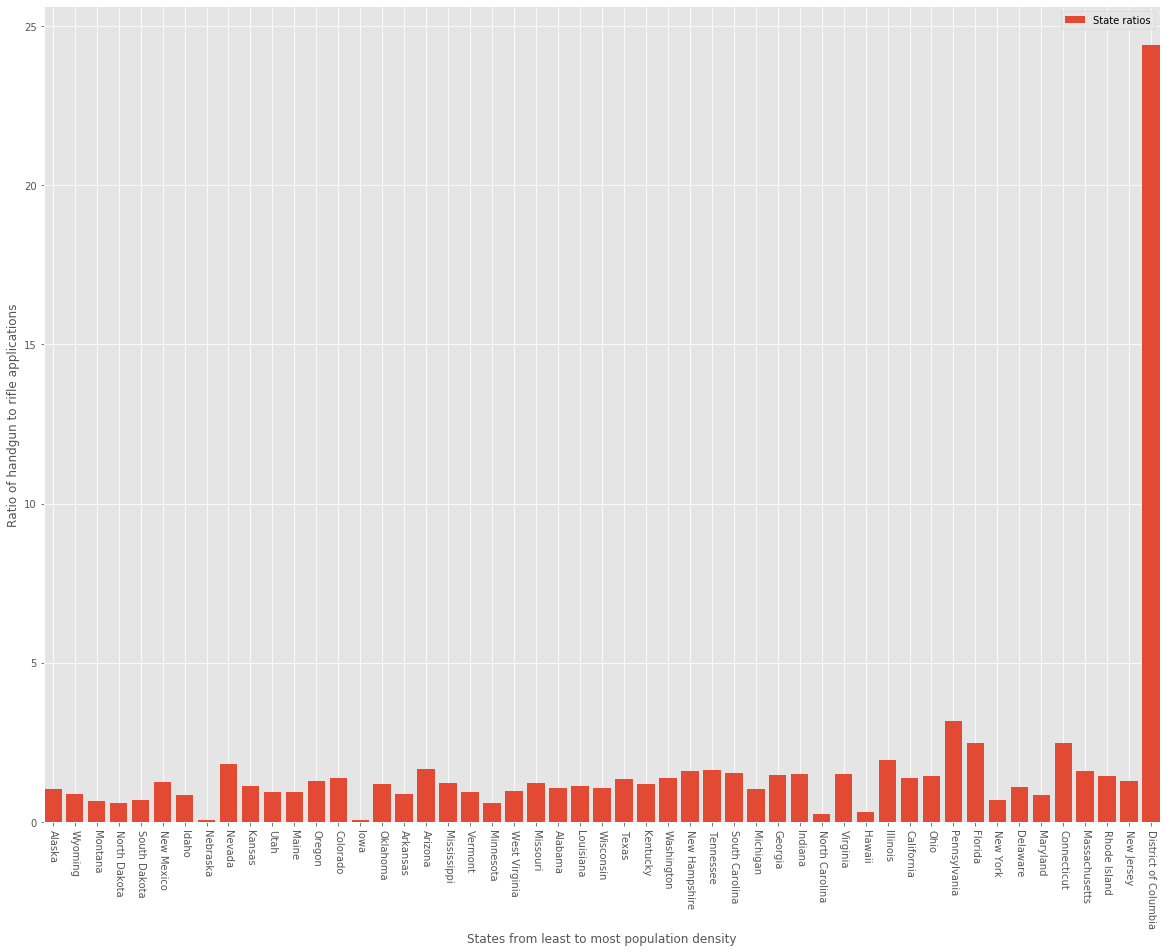

In [7]:
#pop_sorted_nics_2018_df
fig, ax = plt.subplots(figsize=(20,15))
labels = np.array(pop_sorted_nics_2018_df['state'])
h_l_r = np.array(pop_sorted_nics_2018_df['handgun/long_gun'])
x = np.arange(len(labels))
ax.bar(x, h_l_r, label=('State ratios'))
ax.margins(x=0)
ax.set_ylabel('Ratio of handgun to rifle applications')
ax.set_xlabel('States from least to most population density')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=270)
ax.legend()

## Graph 2

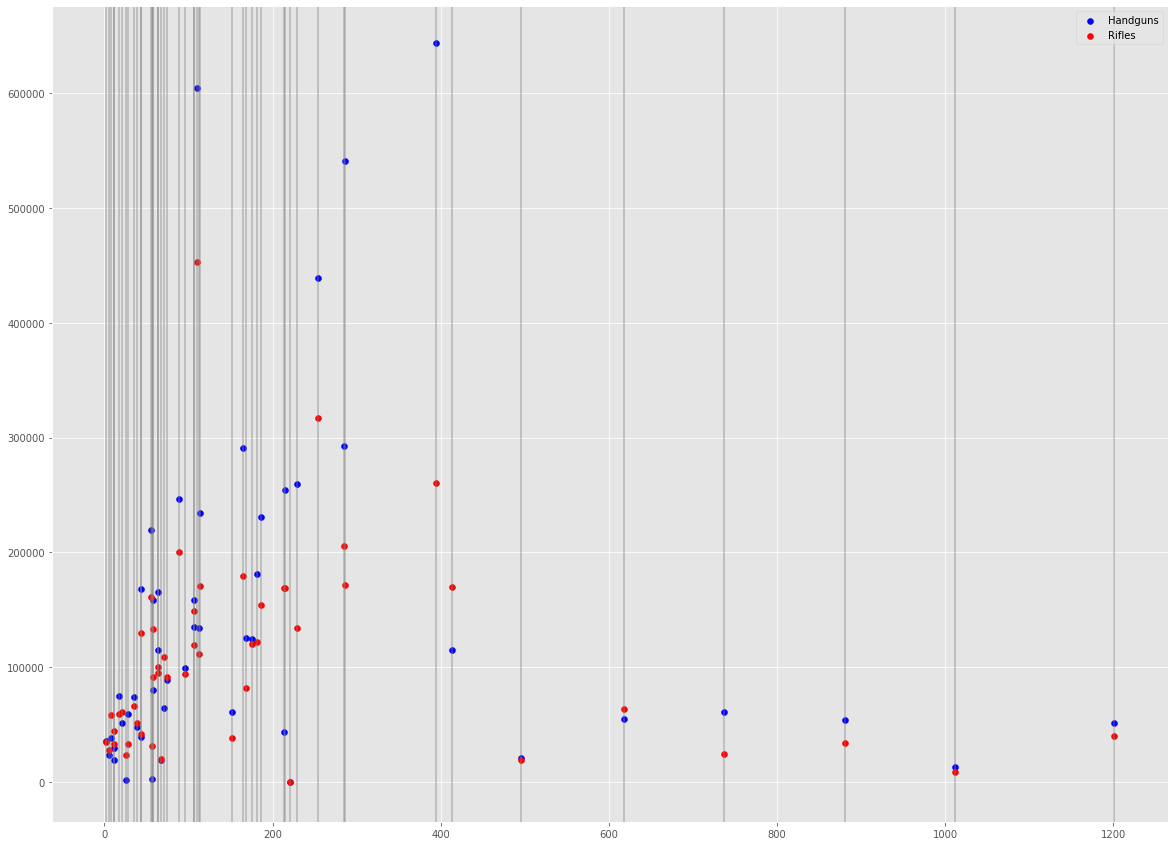

In [8]:
#Remove DC as the obvious outlier 
nics_2018_df_noDC = nics_2018_df[nics_2018_df['state'] != 'District of Columbia']
#Set up plot
fig, ax = plt.subplots(figsize=(20,15))
#Set up variables
x = nics_2018_df_noDC['pop_density']
handgun_y = nics_2018_df_noDC['total_handgun']
long_gun_y = nics_2018_df_noDC['total_long_gun']
#Plot
ax.scatter(x, handgun_y, c='blue', label='Handguns')
ax.scatter(x, long_gun_y, c='red', label='Rifles')
#Label
ax.xlabel = 'Population Density'
ax.ylabel = 'NICS Applications'
for i in x:
    ax.axvline(i, color='grey', alpha=.5)
#ax.axvline(x, color='grey', alpha=.5)
ax.legend()